In [1]:
import torch
import os
import math
import time
import yaml
import pynvml
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import sys
import random
sys.path.append('/home/yang_liu/python_workspace/3DGS')
import torchvision
from os import makedirs
from torch import nn


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scene.datasets import GSDataset
from scene import LargeScene, GaussianModel, GaussianModelLOD
from gaussian_renderer import render, render_v2, render_v3
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from arguments import GroupParams
from utils.general_utils import PILtoTorch
from utils.graphics_utils import getWorld2View2, getProjectionMatrix
from utils.large_utils import which_block, block_filtering
from utils.sh_utils import eval_sh
from transforms3d.euler import euler2mat, mat2euler

WARNED = False

In [2]:
class BlockedGaussian:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0):
        self.xyz = []
        self.opacity = []
        self.rotation = []
        self.scaling = []
        self.features = []
        self.cov3D = []
        self.cell_corners = []
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians):
        with torch.no_grad():
            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, xyz, self.aabb, self.block_dim, self.scale)
                self.xyz.append(xyz[cell_mask])
                self.opacity.append(gaussians.get_opacity[cell_mask])
                self.rotation.append(gaussians.get_rotation[cell_mask])
                self.scaling.append(gaussians.get_scaling[cell_mask])
                self.features.append(gaussians.get_features[cell_mask])
                self.cov3D.append(gaussians.get_covariance(self.scale)[cell_mask])
                xyz_min = xyz[cell_mask].min(dim=0)[0]
                xyz_max = xyz[cell_mask].max(dim=0)[0]
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_xyz(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.xyz[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out

    def get_opacity(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.opacity[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_rotation(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.rotation[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_scaling(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.scaling[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_features(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.features[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out
    
    def get_cov3D(self, indices):
        out = torch.tensor([], device=self.device)
        if len(indices) > self.range[0]:             
            indice_end = min(len(indices), self.range[1])
            out = torch.cat([self.cov3D[indices[i].item()] for i in range(self.range[0], indice_end)])
        return out

class BlockedGaussianV2:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.feats = []
        self.cell_corners = []
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians):
        with torch.no_grad():
            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, xyz, self.aabb, self.block_dim, self.scale)
                if self.compute_cov3D_python:
                    geometry = gaussians.get_covariance(self.scale)[cell_mask].to(self.device)
                else:
                    geometry = torch.cat([gaussians.get_scaling[cell_mask],
                                          gaussians.get_rotation[cell_mask]], dim=1)

                self.feats.append(torch.cat([xyz[cell_mask], 
                                             gaussians.get_opacity[cell_mask],  
                                             gaussians.get_features[cell_mask].reshape(cell_mask.sum(), -1),
                                             geometry], dim=1))
                xyz_min = xyz[cell_mask].min(dim=0)[0]
                xyz_max = xyz[cell_mask].max(dim=0)[0]
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices):
        out = []
        if len(indices) > self.range[0]:
            indice_end = min(len(indices), self.range[1])
            out = [self.feats[indices[i].item()] for i in range(self.range[0], indice_end)]
        return out

class BlockedGaussianV3:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.cell_corners = []
        self.feats = None
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python
        self.cell_ids = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.long, device=self.device)
        self.mask = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.bool, device=self.device)

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians, n=4):
        with torch.no_grad():
            if self.compute_cov3D_python:
                geometry = gaussians.get_covariance(self.scale).to(self.device)
            else:
                geometry = torch.cat([gaussians.get_scaling,
                                      gaussians.get_rotation], dim=1)
            self.feats = torch.cat([gaussians.get_xyz,
                                    gaussians.get_opacity,  
                                    gaussians.get_features.reshape(geometry.shape[0], -1),
                                    geometry], dim=1)

            xyz = gaussians.get_xyz
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, self.feats[:, :3], self.aabb, self.block_dim, self.scale)
                self.cell_ids[cell_mask] = cell_idx
                # MAD to eliminate influence of outsiders
                xyz_median = torch.median(xyz[cell_mask], dim=0)[0]
                delta_median = torch.median(torch.abs(xyz[cell_mask] - xyz_median), dim=0)[0]
                xyz_min = xyz_median - n * delta_median
                xyz_min = torch.max(xyz_min, torch.min(xyz[cell_mask], dim=0)[0])
                xyz_max = xyz_median + n * delta_median
                xyz_max = torch.min(xyz_max, torch.max(xyz[cell_mask], dim=0)[0])
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices):
        out = torch.tensor([], device=self.device, dtype=self.feats.dtype)
        if len(indices) > self.range[0]:
            indice_end = min(len(indices), self.range[1])
            self.mask = torch.isin(self.cell_ids, indices[self.range[0]:indice_end].to(self.device))
            out = self.feats[self.mask]
        return out

class Camera(nn.Module):
    def __init__(self, colmap_id, R, T, FoVx, FoVy, image, gt_alpha_mask,
                 image_name, uid,
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        self.uid = uid
        self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        self.image_name = image_name

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            print(e)
            print(f"[Warning] Custom device {data_device} failed, fallback to default cuda device" )
            self.data_device = torch.device("cuda")

        self.original_image = image.clamp(0.0, 1.0).to(self.data_device)
        self.image_width = self.original_image.shape[2]
        self.image_height = self.original_image.shape[1]

        if gt_alpha_mask is not None:
            self.original_image *= gt_alpha_mask.to(self.data_device)
        else:
            self.original_image *= torch.ones((1, self.image_height, self.image_width), device=self.data_device)

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        # world_view_transform = getWorld2View2(R, T, trans, scale)
        # if angle_delta is not None:
        #     R = world_view_transform[:3, :3]
        #     euler = np.array(mat2euler(R)) * 180 / np.pi
        #     euler += angle_delta
        #     R = euler2mat(*euler * np.pi / 180)
        #     world_view_transform[:3, :3] = R

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1).cuda()
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]

def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def in_frustum(viewpoint_cam, cell_corners, aabb, block_dim):
    num_cell = cell_corners.shape[0]
    device = cell_corners.device

    cell_corners = torch.cat([cell_corners, torch.ones_like(cell_corners[..., [0]])], dim=-1)
    cam_center = viewpoint_cam.camera_center
    full_proj_transform = viewpoint_cam.full_proj_transform.repeat(num_cell, 1, 1)
    viewmatrix = viewpoint_cam.world_view_transform.repeat(num_cell, 1, 1)
    cell_corners_screen = cell_corners.bmm(full_proj_transform)
    cell_corners_screen = cell_corners_screen / cell_corners_screen[..., [-1]]
    cell_corners_screen = cell_corners_screen[..., :-1]

    cell_corners_cam = cell_corners.bmm(viewmatrix)
    mask = (cell_corners_cam[..., 2] > 0.2)

    cell_corners_screen_min = torch.zeros((num_cell, 3), dtype=torch.float32, device=device)
    cell_corners_screen_max = torch.zeros((num_cell, 3), dtype=torch.float32, device=device)

    for i in range(num_cell):
        if mask[i].sum() > 0:
            cell_corners_screen_min[i] = cell_corners_screen[i][mask[i]].min(dim=0).values
            cell_corners_screen_max[i] = cell_corners_screen[i][mask[i]].max(dim=0).values

    box_a = torch.cat([cell_corners_screen_min[:, :2], cell_corners_screen_max[:, :2]], dim=1)
    box_b = torch.tensor([[-1, -1, 1, 1]], dtype=torch.float32, device=device)
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                    box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                    box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    mask = (inter[:, 0, 0] * inter[:, 0, 1]) > 0

    cam_center_id = which_block(cam_center[None, :], aabb, block_dim)[0]
    mask[cam_center_id] = True

    return mask

def load_gaussians(cfg, config_name, iteration=30_000, load_vq=False, deivce='cuda', source_path='../data/matrix_city/aerial/test/block_all_test'):
    
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', cfg)
    lp.source_path = source_path
    lp.model_path = os.path.join("../output/", config_name)

    modules = __import__('scene')
    
    with torch.no_grad():
        if 'apply_voxelize' in lp.model_config['kwargs'].keys():
            lp.model_config['kwargs']['apply_voxelize'] = False
        gaussians = getattr(modules, lp.model_config['name'])(lp.sh_degree, device=deivce, **lp.model_config['kwargs'])
        scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)
        print(f'Init {config_name} with {len(gaussians.get_opacity)} points\n')

    return gaussians, scene

def loadCam(args, id, cam_info, resolution_scale, angle_delta=None):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if angle_delta is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3])) * 180 / np.pi
        euler += angle_delta
        C2W[:3, :3] = euler2mat(*euler * np.pi / 180)
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

def loadCamV2(args, id, cam_info, resolution_scale, pitch=None, height=None):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if height is not None and pitch is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3])) * 180 / np.pi
        euler[0] = pitch
        C2W[:3, :3] = euler2mat(*euler * np.pi / 180)
        C2W[2, -1] = height
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

def render_lod(viewpoint_cam, lod_list : list, pipe, bg_color : torch.Tensor, scaling_modifier = 1.0, override_color = None):
        
        # sort cells by distance to camera

        in_frustum_mask = in_frustum(viewpoint_cam, lod_list[-1].cell_corners, lod_list[-1].aabb, lod_list[-1].block_dim)
        in_frustum_indices = in_frustum_mask.nonzero().squeeze(0)
        cam_center = viewpoint_cam.camera_center
        distance3D = torch.norm(lod_list[-1].cell_corners[in_frustum_mask, :, :2] - cam_center[:2], dim=2).min(dim=1).values
        in_frustum_indices = in_frustum_indices[torch.sort(distance3D)[1]]
        
        # used for BlockedGaussianV3
        out_list = []
        main_device = lod_list[-1].feats.device
        max_sh_degree = lod_list[-1].max_sh_degree
        feat_end_dim = 3 * (max_sh_degree + 1) ** 2 + 4
        
        for lod_gs in lod_list:
            out_i = lod_gs.get_feats(in_frustum_indices)
            if out_i.shape[0] == 0:
                continue
            if out_i.device != main_device:
                out_i = torch.cat([out_i[:, :3].to(main_device), out_i[:, 3:].half().to(main_device)], dim=1)
            out_list.append(out_i)

        feats = torch.cat(out_list, dim=0)
        # feats = lod_list[1].feats

        means3D = feats[:, :3].float()
        screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
        means2D = screenspace_points
        opacity = feats[:, 3].float()
        # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
        # scaling / rotation by the rasterizer.
        scales = None
        rotations = None
        cov3D_precomp = None
        if pipe.compute_cov3D_python:
            cov3D_precomp = feats[:, feat_end_dim:].float()
        else:
            scales = feats[:, feat_end_dim:feat_end_dim+3].float()
            rotations = feats[:, (feat_end_dim+3):].float()
            
        # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
        # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
        shs = None
        colors_precomp = None
        if override_color is None:
            features = feats[:, 4:feat_end_dim].reshape(-1, (max_sh_degree+1)**2, 3).float()
            if pipe.convert_SHs_python:
                shs_view = features.transpose(1, 2).view(-1, 3, (max_sh_degree+1)**2)
                dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
                dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
                sh2rgb = eval_sh(max_sh_degree, shs_view, dir_pp_normalized)
                colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
            else:
                shs = features
        else:
            colors_precomp = override_color  # check if requires masking
        
        # Set up rasterization configuration
        tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
        tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

        raster_settings = GaussianRasterizationSettings(
            image_height=int(viewpoint_cam.image_height),
            image_width=int(viewpoint_cam.image_width),
            tanfovx=tanfovx,
            tanfovy=tanfovy,
            bg=bg_color,
            scale_modifier=scaling_modifier,
            viewmatrix=viewpoint_cam.world_view_transform,
            projmatrix=viewpoint_cam.full_proj_transform,
            sh_degree=max_sh_degree,
            campos=viewpoint_cam.camera_center, 
            prefiltered=False,
            debug=pipe.debug
        )

        rasterizer = GaussianRasterizer(raster_settings=raster_settings)

        rendered_image, radii = rasterizer(
            means3D = means3D,
            means2D = means2D,
            shs = shs,
            colors_precomp = colors_precomp,
            opacities = opacity,
            scales = scales,
            rotations = rotations,
            cov3D_precomp = cov3D_precomp)
        
        # Those Gaussians that were frustum culled or had a radius of 0 were not visible.
        # They will be excluded from value updates used in the splitting criteria.
        return {"render": rendered_image,
                "viewspace_points": screenspace_points,
                "visibility_filter" : radii > 0,
                "radii": radii}

## 6. Render the whole dataset without LoD

In [3]:
import time
import torchvision
from os import makedirs
from torch.profiler import profile, record_function, ProfilerActivity

In [4]:
iteration = 30_000

config = '../config/block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq.yaml'
config_name = os.path.splitext(os.path.basename(config))[0]
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    # cfg['model_params']['model_config']['name'] = "GaussianModel"
gaussians, scene = load_gaussians(cfg, config_name, iteration=None, load_vq=True, deivce='cuda')

lp, op, pp = parse_cfg(cfg)
setattr(lp, 'config_path', cfg)
lp.source_path = '../data/matrix_city/aerial/test/block_all_test'
scaling_modifier = 1.0
override_color = None
angle_delta = None

Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq with 11782801 points



In [5]:
model_path = os.path.join("../output/", "block_mc_aerial_block_all_lr_c36_loss_5")
name = "block_all_test"

# indexing is the most time_consuming part
# angle_delta = np.array([0, 0, 0])
# render_path = os.path.join(model_path, name, "ours_{}".format(iteration), "renders")
# gts_path = os.path.join(model_path, name, "ours_{}".format(iteration), "gt")

pitch, height = -180, 20
# render_path = os.path.join(model_path, name, "ours_{}_pitch{}_height{}".format(iteration, pitch, height), "renders")
# gts_path = os.path.join(model_path, name, "ours_{}_pitch{}_height{}".format(iteration, pitch, height), "gt")

# makedirs(render_path, exist_ok=True)
# makedirs(gts_path, exist_ok=True)
pynvml.nvmlInit()

In [7]:
with torch.no_grad():
    
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    avg_render_time = 0
    max_render_time = 0
    avg_memory = 0
    visible_pts_cnt_single = []

    for idx in tqdm(range(len(views))):
        
    # idx = 518

        # viewpoint_cam = loadCam(lp, idx, views[idx], 1.0, angle_delta)
        viewpoint_cam = loadCamV2(lp, idx, views[idx], 1.0, pitch, height)

        torch.cuda.empty_cache()

        start = time.time()
        render_pkg = render(viewpoint_cam, gaussians, pp, background)
        end = time.time()

        handle = pynvml.nvmlDeviceGetHandleByIndex(5)
        memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        memory_used = memory_info.used / 1024 / 1024
        visible_pts_cnt_single.append(render_pkg['visibility_filter'].sum().item())

        # torch.cuda.empty_cache()

    # image = render_pkg["render"]

    # image = image.cpu().numpy().transpose(1,2,0)

    # show render results
    # plt.figure(figsize=(8, 8))
    # plt.imshow(image)
    # plt.title(f"Idx {idx}, Rendered {render_pkg['visibility_filter'].sum().item()} / {render_pkg['radii'].shape[0]} points")
    # plt.axis(False)
    # plt.tight_layout()
    # plt.show()
        avg_memory += memory_used
        avg_render_time += end-start
        max_render_time = max(max_render_time, end-start)

        # torchvision.utils.save_image(render_pkg["render"], os.path.join(render_path, '{0:05d}'.format(idx) + ".png"))
        # torchvision.utils.save_image(viewpoint_cam.original_image[0:3, :, :], os.path.join(gts_path, '{0:05d}'.format(idx) + ".png"))

    print(f'Average FPS: {len(views)/avg_render_time:.4f}')
    print(f'Min FPS: {1/max_render_time:.4f}')
    print(f'Average Memory: {avg_memory/len(views):.4f} M')

100%|██████████| 741/741 [02:22<00:00,  5.20it/s]

Average FPS: 57.2602
Min FPS: 1.1795
Average Memory: 7312.5326 M


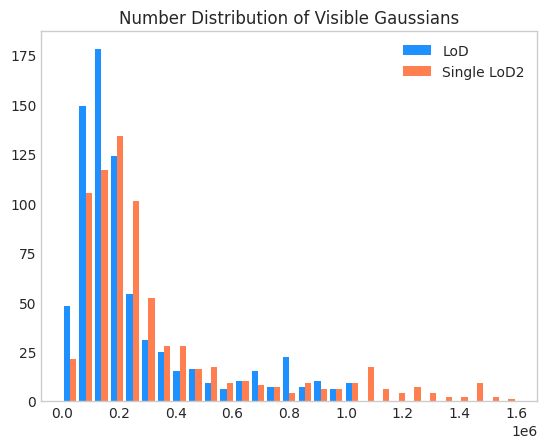

In [24]:
# plot histagram of visible_pts_cnt
plt.figure()
plt.style.use('seaborn-whitegrid')

bins = np.linspace(0, 1.6e6, 30)
plt.hist([visible_pts_cnt, visible_pts_cnt_single], bins, label=['LoD', 'Single LoD2'], color=['dodgerblue', 'coral'])
plt.title("Number Distribution of Visible Gaussians")
plt.legend(loc='upper right')
plt.grid(False)
plt.show()